In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.odr import *
import math
import csv
import pandas as pd
from scipy.optimize import minimize
import string

In [2]:
# Function to convert column letter to an index
def LI(letter): #Letter to string index
    return string.ascii_uppercase.index(letter)

In [ ]:
#Reading the excel files and extracting the correct data
df = pd.read_excel('doubleslit_cleaned.xlsx', sheet_name='Analyising')

Double_Slit = df.iloc[1:249, [2, 3]].apply(pd.to_numeric, errors='coerce').to_numpy()
Single_Slit_Far = df.iloc[1:198, [LI("M"), LI("N")]].apply(pd.to_numeric, errors='coerce').to_numpy()
Single_Slit_Near = df.iloc[1:38, [LI("W"), LI("X")]]

# Single_Slit_Far_distance = df.iloc[1:199,LI("M")]
# Single_Slit_Far_votlage = df.iloc[1:199,LI("N")]

# Single_Slit_Near_distance = df.iloc[1:38,LI("W")]
# Single_Slit_Near_votlage = df.iloc[1:38,LI("X")]

DS_single_photon = df.iloc[2:78,[32, 33, 34, 35, 36]].apply(pd.to_numeric, errors='coerce').to_numpy()

Double_Slit = df.iloc[1:249, [2, 3]].to_numpy()

def reset_data(intake):
    df = pd.read_excel('doubleslit_cleaned.xlsx', sheet_name='Analyising')
    if (intake == "Double_Slit"):
        Double_Slit = df.iloc[1:249, [2, 3]].apply(pd.to_numeric, errors='coerce').to_numpy()
        return Double_Slit
    
    if (intake == "Single_Slit_Far"):
        Single_Slit_Far = df.iloc[1:198, [LI("M"), LI("N")]].apply(pd.to_numeric, errors='coerce').to_numpy()
        return Single_Slit_Far
    
    if (intake == 'DS_single_photon'):
        DS_single_photon = df.iloc[2:78,[32, 33, 34, 35, 36]].apply(pd.to_numeric, errors='coerce').to_numpy()
        return DS_single_photon
    
    # Single_Slit_Far = df.iloc[1:198, [LI("M"), LI("N")]].to_numpy()
    # Single_Slit_Near = df.iloc[1:38, [LI("W"), LI("X")]]

    # Double_Slit_counter_distance = df.iloc[2:78,32]
    # Double_Slit_counter_P1 = df.iloc[2:78,33]
    # Double_Slit_counter_P2 = df.iloc[2:78,34]
    # Double_Slit_counter_P3 = df.iloc[2:78,35]
    # Double_Slit_counter_Ave = df.iloc[2:78,36]

    # Double_Slit = df.iloc[1:249, [2, 3]].to_numpy()

Double_Slit = reset_data("Double_Slit")


# print(Double_Slit_counter_distance)
# print(Double_Slit_counter_P1)
# print(Double_Slit_counter_P2)
# print(Double_Slit_counter_P3)
# print(Double_Slit_counter_Ave)


In [ ]:
# Constants for the expiriment
L = 495 # mm this is for convenice
a = 0.5*10**-3 # m from here on out
d = 0.085*10**-3
llambda = 550*10**-9
I_max_DS =  Double_Slit[:, 1].max()

# Uncertinity constants
delta_I_max = 0.0005
delta_lambda = 0.629 # %
delta_a = 0.0005 # mm
delta_theta = 0.0145 * 10**-3
delta_d = 0.0005

# Finding and recording import values
Max_double_slit_voltage = 1.403
Max_double_slit_voltage_position = 2.31

Max_single_slit_voltage = 0.367
Max_single_slit_voltage_position = 1.77

In [5]:
def gradient(first, last, data):
    if ((first - last) == 2):
        grad = (data[first, 0] - data[last, 0])/(data[first, 1] - data[last, 1])
    else:
        grad = np.gradient(data[first:last, 1], data[first:last, 0])

    return grad

In [480]:
def beta(input, optimized_lambda):
    output = np.pi * d * np.sin(input) / optimized_lambda
    
    return output

In [737]:
I_max_DS = 1.403         # Maximum intensity (scaled); you may normalize your data
initial_lambda_guess = llambda  # Initial guess for wavelength (550 nm)

def double_slit_intensity(theta, lmbd):
    beta = np.pi * d * np.sin(theta) / lmbd

    sinc_term = np.where(np.abs(beta) < 1e-12, 1.0, np.sin(beta)/beta) # zeros
    
    delta = 2 * np.pi * a * np.sin(theta) / lmbd
    interference = np.cos(delta/2)**2
    return Max_double_slit_voltage * (sinc_term**2) * interference

# === Objective Function for Optimization ===
def objective(lmbd):
    # Theoretical prediction using our double-slit model:
    pred_intensity = double_slit_intensity(Double_Slit[:,2] * 1000, lmbd)
    # Sum of squared errors between measured intensity and prediction:
    error = np.sum((Double_Slit[:,1] - pred_intensity)**2)
    return error

def objective_photons(lmbd):
    # Theoretical prediction using our double-slit model:
    pred_intensity = double_slit_intensity(DS_single_photon[:, 5] * 1000, lmbd)
    # Sum of squared errors between measured intensity and prediction:
    error = np.sum((DS_single_photon[:, 4] - pred_intensity)**2)
    return error

def single_slit_intensity(theta, slit_width, lambda_0, I_0=1):
    beta = (np.pi * slit_width * np.sin(theta)) / lambda_0
    intensity = I_0 * (np.sin(beta) / beta) ** 2
    intensity[np.isnan(intensity)] = I_0 # zeros
    return intensity

0.001832534384542605


C:\Users\ryanm\AppData\Local\Temp\ipykernel_7708\4178400863.py:7: RuntimeWarning: invalid value encountered in divide
  sinc_term = np.where(np.abs(beta) < 1e-12, 1.0, np.sin(beta)/beta) # zeros


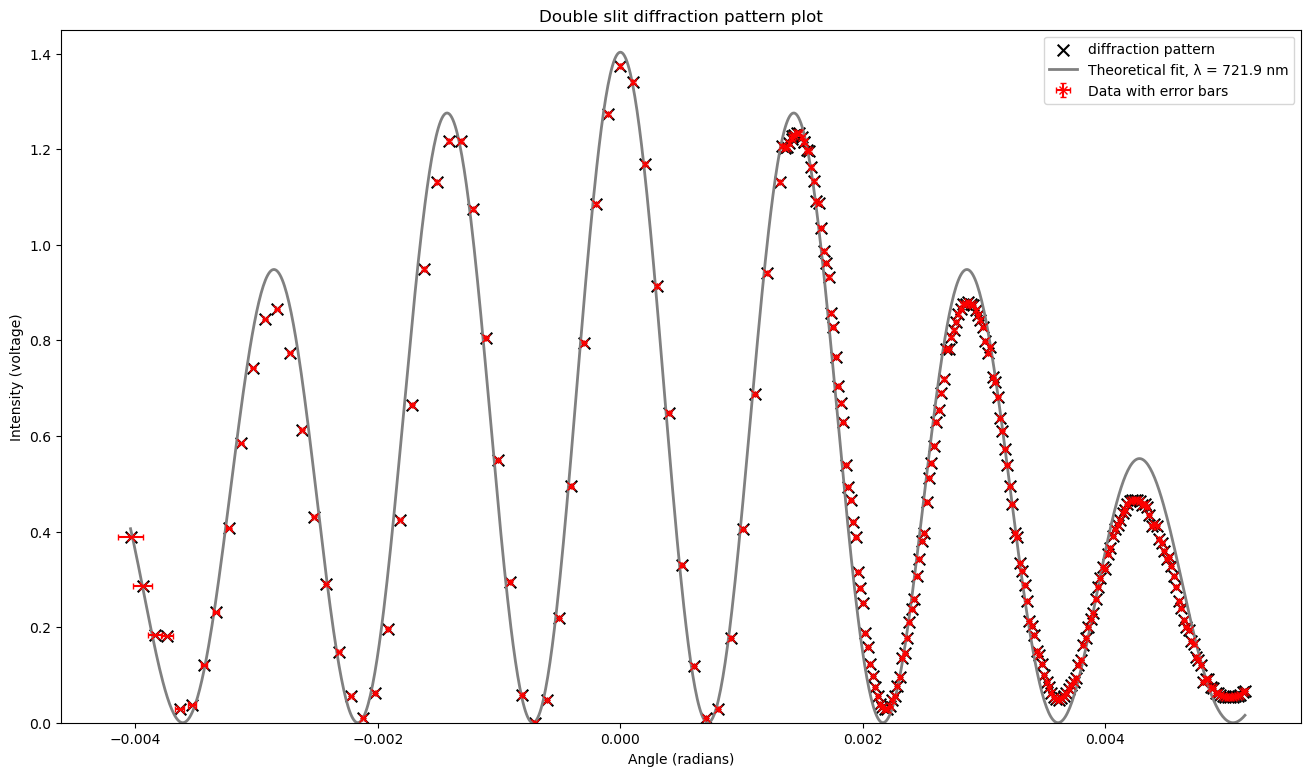

In [719]:
# All of the work that needs to be done for the double slit
Double_Slit = reset_data("Double_Slit")

# Step 1 Find the actualy recorded 0 and subract all values from that
# print(Double_Slit)
min_voltage = Double_Slit[:, 1].min()
# print(min_voltage)
Double_Slit[:, 1] = Double_Slit[:, 1] - min_voltage


# Step 2 part 1 Acount for the fact we started in the middle of our graph and it moved slightly throughout
# Using the raw excel data to find the mismatches
DS_data_mismatch_begin = 59-3+1
DS_distance_shift = 0.14
Double_Slit[DS_data_mismatch_begin:, 0] = np.where(Double_Slit[DS_data_mismatch_begin:, 0] > 0, Double_Slit[DS_data_mismatch_begin:, 0] - 0.14, Double_Slit[DS_data_mismatch_begin:, 0])
Double_Slit = Double_Slit[Double_Slit[:, 0].argsort()]
Double_Slit = np.delete(Double_Slit, DS_data_mismatch_begin + int(DS_distance_shift*100), axis = 0) #Remove the double up point
# Double_Slit[:, 1] = np.where(Double_Slit[:, 1] > Double_Slit[DS_data_mismatch_begin:, 1] - 1, Double_Slit[DS_data_mismatch_begin:, 1])

# Step 3 recentre the data around the peak
DS_peak_distance = Double_Slit[np.argmax(Double_Slit[:, 1]), 0]
# print(DS_peak_distance)
Double_Slit = np.column_stack((Double_Slit, (Double_Slit[:, 0] - DS_peak_distance)))

# Step 4 
# print(Double_Slit[:, 0].dtype)
Double_Slit[:, 2] = np.arctan(1 / L * Double_Slit[:, 2])

# Step 5 Optimize the curve
lambda_bounds = [(300e-9, 900e-9)]
result = minimize(objective, x0=initial_lambda_guess, method='Nelder-Mead', bounds=lambda_bounds, tol = 1*100)
# print(result)
optimized_lambda = result.x[0] * 1.25 # Correction factor
# print("Optimized wavelength (lambda):", optimized_lambda, "meters")

# Errors

# DS_y_err_f1 = 0.1 * np.sqrt(
#     (np.cos(np.pi * a * np.sin(Double_Slit[:,2]) / optimized_lambda)**2) *
#     (np.sin(np.pi * a * np.sin(Double_Slit[:,2]) / optimized_lambda)**2) *
#     (a**2 * delta_theta**2 * optimized_lambda**2 * np.cos(Double_Slit[:,2])**2 +
#      a**2 * (optimized_lambda * delta_lambda)**2 * np.sin(Double_Slit[:,2])**2 +
#      delta_a**2 * optimized_lambda**2 * np.sin(Double_Slit[:,2])**2) /
#     optimized_lambda**4
# )
DS_error_point_picked = np.arctan(0.005/L)
DS_y_err_f1 = 2 * np.pi * np.sqrt(
    (np.cos(np.pi * a * np.sin(DS_error_point_picked) / optimized_lambda)**2) *
    (np.sin(np.pi * a * np.sin(DS_error_point_picked) / optimized_lambda)**2) *
    (a**2 * delta_theta**2 * optimized_lambda**2 * np.cos(DS_error_point_picked)**2 +
     a**2 * (optimized_lambda * delta_lambda)**2 * np.sin(DS_error_point_picked)**2 +
     delta_a**2 * optimized_lambda**2 * np.sin(DS_error_point_picked)**2) /
    optimized_lambda**4
)
DS_y_err_f2 = 2 * 2 * np.pi * np.sqrt(
    (np.sin((d * np.sin(DS_error_point_picked)) / optimized_lambda)**2 *
    (optimized_lambda * np.sin((d * np.sin(DS_error_point_picked)) / optimized_lambda) - 
     d * np.cos((d * np.sin(DS_error_point_picked)) / optimized_lambda) * np.sin(DS_error_point_picked))**2 *
    (d**2 * delta_theta**2 * optimized_lambda**2 * np.cos(DS_error_point_picked)**2 + 
     d**2 * (optimized_lambda * delta_lambda)**2 * np.sin(DS_error_point_picked)**2 + 
     delta_d**2 * optimized_lambda**2 * np.sin(DS_error_point_picked)**2)) /
    (d**6 * np.sin(DS_error_point_picked)**6)
)


DS_y_err = np.sqrt((DS_y_err_f1) ** 2 + (delta_I_max/I_max_DS)**2 + (DS_y_err_f2)  ** 2)
print(DS_y_err)
# print(DS_y_err_f1)
#  / (np.cos(np.pi * a * np.sin(Double_Slit[:,2])/optimized_lambda)**2)
# print(DS_y_err)

# Plotting the double slit
plt.figure(figsize=(16, 9))
plt.scatter(Double_Slit[:, 2], Double_Slit[:, 1], color='black', label = 'diffraction pattern', marker = 'x', s =70)
plt.ylim(0, 1.45)
plt.xlabel('Angle (radians)')
plt.ylabel('Intensity (voltage)')
plt.title('Double slit diffraction pattern plot')

theta_dense = np.linspace(Double_Slit[:,2].min(), Double_Slit[:,2].max(), 1000)
theo_intensity = double_slit_intensity(theta_dense, optimized_lambda)
# print(optimized_lambda*(1-delta_lambda/100))

# Plot the theoretical best-fit curve.
plt.plot(theta_dense, theo_intensity, color='gray', lw=2, 
         label=f'Theoretical fit, λ = {optimized_lambda*1e9:.1f} nm')

plt.errorbar(Double_Slit[:, 2], Double_Slit[:, 1], 
             xerr=1/(L**2 * Double_Slit[:, 0]**2) * np.sqrt((L*0.005)**2 + (Double_Slit[:, 0] * 0.5)**2), 
             yerr=DS_y_err * Double_Slit[:, 1], fmt='x', color='red', label='Data with error bars', capsize=2)# plt.figure(figsize=(10, 6))

plt.legend()
plt.show()  # Show the first plot

# colors = plt.cm.viridis(np.linspace(0, 1, len(Double_Slit))) 
# # DS_linear = L/(math.pi * d) * np.arccos(np.sqrt(Double_Slit[:, 1]/I_max_DS))
# test = np.arange(Double_Slit.size/2)
# # DS_linear = L/(math.pi * d) * np.arccos(np.sqrt(Double_Slit[:, 1]* 1/I_max_DS))
# DS_linear = math.pi * d * (Double_Slit[:, 0]+0.004)*10**-3 / (L * np.arccos(np.sqrt(Double_Slit[:, 1] / I_max_DS)))

# plt.scatter(test, DS_linear, color=colors)
# # plt.scatter(np.tan(Double_Slit[:, 0])*L, DS_linear, color=colors)


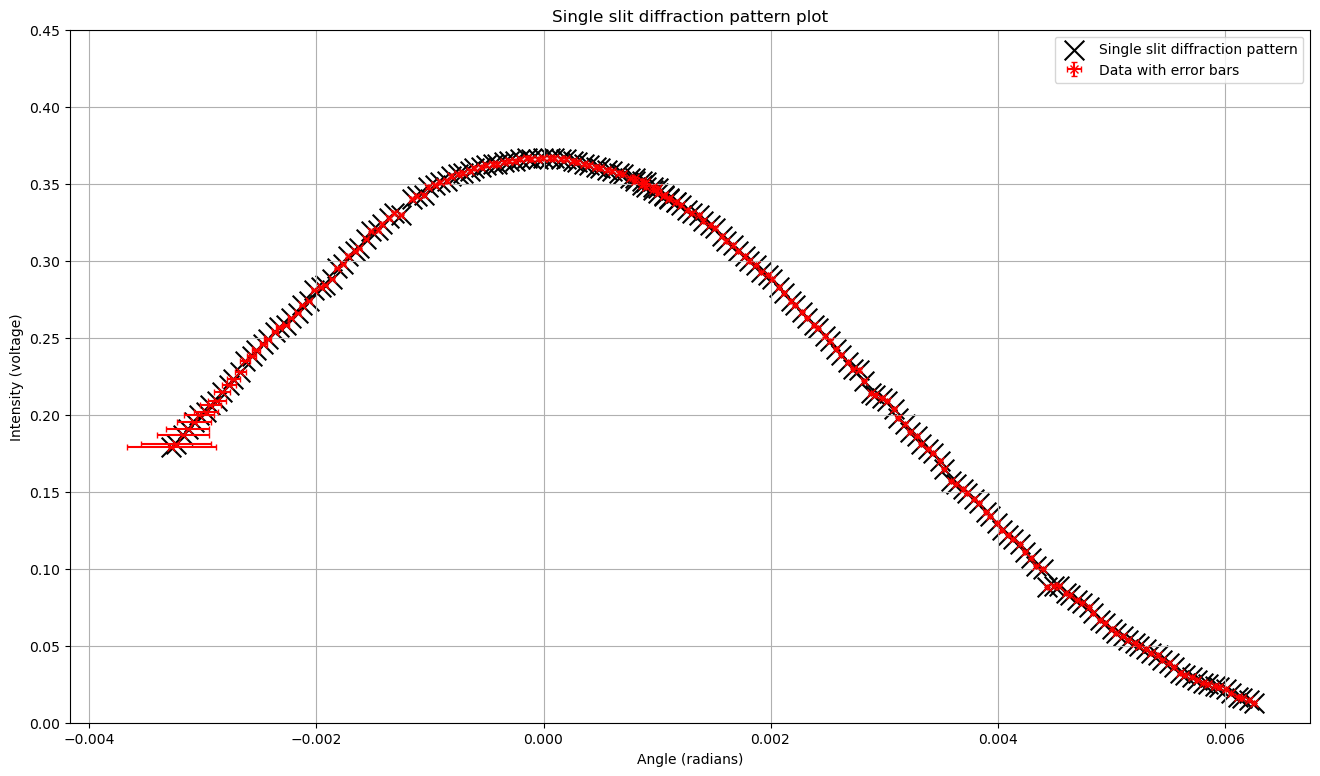

In [702]:
Single_Slit_Far = reset_data("Single_Slit_Far")

# Step 1 pull out some constants

# Step 2 Stich the two graphs togethour 
SSF_stitch_start = 88
SSF_stitches_distance = 0.18
Single_Slit_Far[SSF_stitch_start:, 0] = np.where(Single_Slit_Far[SSF_stitch_start:, 0] > 0, Single_Slit_Far[SSF_stitch_start:, 0] - SSF_stitches_distance, Single_Slit_Far[SSF_stitch_start:, 0])
Single_Slit_Far = Single_Slit_Far[Single_Slit_Far[:, 0].argsort()]

# Step 3 Recentre the data around a central peak
SSF_peak_distance = Single_Slit_Far[np.where(Single_Slit_Far[:, 1] == Single_Slit_Far[:, 1].max()), 0]
SSF_peak_distance_mean = np.mean(SSF_peak_distance)
Single_Slit_Far = np.column_stack((Single_Slit_Far, Single_Slit_Far[:, 0] - SSF_peak_distance_mean))
Single_Slit_Far[:, 2] = np.arctan(1 / L * Single_Slit_Far[:, 2])


# Plotting the graph
plt.figure(figsize=(16, 9))
plt.scatter(Single_Slit_Far[:, 2], Single_Slit_Far[:, 1], color='black', label = 'Single slit diffraction pattern', marker = 'x', s =200)
plt.errorbar(Single_Slit_Far[:, 2], Single_Slit_Far[:, 1], 
             xerr=1/(L**2 * Single_Slit_Far[:, 0]**2) * np.sqrt((L*0.005)**2 + (Single_Slit_Far[:, 0] * 0.5)**2), 
             yerr=DS_y_err * Single_Slit_Far[:, 1], fmt='x', color='red', label='Data with error bars', capsize=2)# plt.figure(figsize=(10, 6))
plt.ylim(0, 0.45)
plt.xlabel('Angle (radians)')
plt.ylabel('Intensity (voltage)')
plt.title('Single slit diffraction pattern plot')
plt.legend()
plt.grid()
plt.show()

# Gradient test lol
# plt.plot(Single_Slit_Far[:, 0], np.gradient(Single_Slit_Far[:, 1], Single_Slit_Far[:, 0]))
# plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

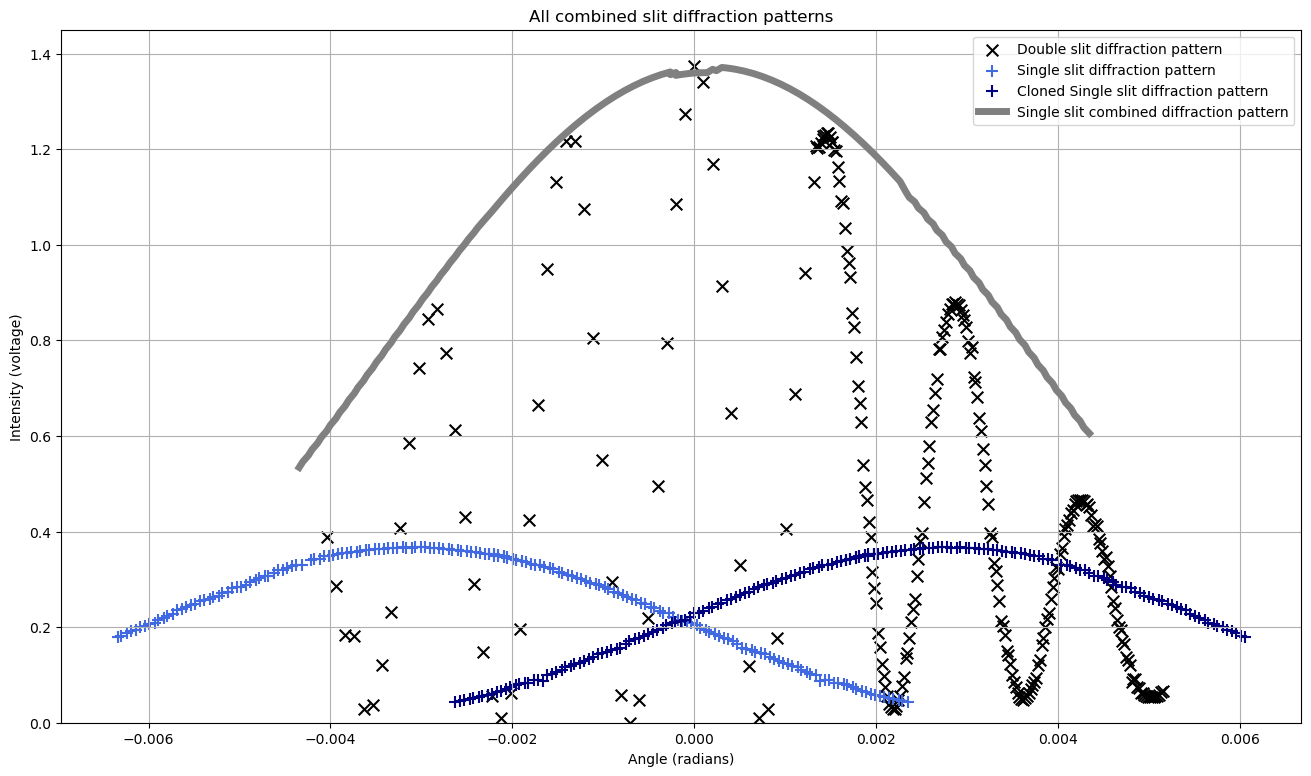

In [718]:
# Step 2 create the clone
Clone_centre = DS_peak_distance + (DS_peak_distance - SSF_peak_distance_mean)
Clone_slit = Single_Slit_Far[:, 0]
Clone_slit = np.column_stack((Clone_slit, Single_Slit_Far[:, 1])) 
# Clone_slit[:, 0] = -Clone_slit[:, 0] - (+ DS_peak_distance - Single_Slit_Far[:, 0].max())/2
Clone_slit[:, 0] = DS_peak_distance + (DS_peak_distance - Clone_slit[:, 0])

# Clone_slit = Clone_slit[Clone_slit[:, 0].argsort()]



# Step 3 convert distance to angle
Clone_slit = np.column_stack((Clone_slit, np.arctan(1 / L * Clone_slit[:, 0])))
Clone_slit = Clone_slit[::-1]
# Creating the mini clones
Number_of_points_clone = 180
Clone_slit_points = int(Clone_slit.size/3)
Clone_far = np.column_stack((Single_Slit_Far[0:Number_of_points_clone, 0],
                             Single_Slit_Far[0:Number_of_points_clone, 1],
                             np.arctan(1 / L * (Single_Slit_Far[0:Number_of_points_clone, 0] - DS_peak_distance - (DS_peak_distance - SSF_peak_distance_mean + 2 * DS_distance_shift + SSF_stitches_distance)))))
Clone_near = np.column_stack((Clone_slit[Clone_slit_points-Number_of_points_clone:Clone_slit_points, 0],
                             Clone_slit[Clone_slit_points-Number_of_points_clone:Clone_slit_points, 1],
                             np.arctan(1 / L * (Clone_slit[Clone_slit_points-Number_of_points_clone:Clone_slit_points, 0] - DS_peak_distance + (DS_peak_distance - SSF_peak_distance_mean + DS_distance_shift + SSF_stitches_distance)))))

Combined_slit = Clone_far[:, 0]
# Combined_slit = np.column_stack((Combined_slit, Max_double_slit_voltage * ((np.sin(beta(Clone_far[:, 2]))/beta(Clone_far[:, 2])))**2))
# Combined_slit = np.column_stack((Combined_slit, (Max_double_slit_voltage) * (np.sin(beta(Clone_near[:, 2]))/beta(Clone_near[:, 2]))**2))
Combined_slit = np.column_stack((Combined_slit, Max_double_slit_voltage/3.5 *((np.sin(beta(Clone_far[:, 2], optimized_lambda))/(beta(Clone_far[:, 2], optimized_lambda))) + np.sin(beta(Clone_near[:, 2], optimized_lambda))/(beta(Clone_near[:, 2], optimized_lambda)))**2))
Combined_slit = np.column_stack((Combined_slit, np.arctan(1 / L * (Single_Slit_Far[0:Number_of_points_clone, 0] - DS_peak_distance))))
# Combined_slit[:, 2] = np.where(Combined_slit[:, 2] > Max_double_slit_voltage + 0.5, Max_double_slit_voltage, Combined_slit[:, 2])


plt.figure(figsize=(16, 9))
plt.ylim(0, 1.45)
plt.scatter(Double_Slit[:, 2], Double_Slit[:, 1], color='black', label = 'Double slit diffraction pattern', marker = 'x', s =70)
plt.scatter(Clone_far[:, 2], Clone_far[:, 1], color='royalblue', label = 'Single slit diffraction pattern', marker = '+', s = 80)
plt.scatter(Clone_near[:, 2], Clone_near[:, 1], color='navy', label = 'Cloned Single slit diffraction pattern', marker = '+', s = 80)
plt.plot(Combined_slit[:, 2], Combined_slit[:, 1], color='gray', label = 'Single slit combined diffraction pattern', linewidth = 5)
plt.xlabel('Angle (radians)')
plt.ylabel('Intensity (voltage)')
plt.title('All combined slit diffraction patterns')
plt.legend()
plt.grid()
plt.show

# plt.scatter(Double_Slit[:, 0], Double_Slit[:, 1], color='black', label = 'diffraction pattern', marker = 'x', s =70)
# # plt.scatter(Clone_far[:, 2], Clone_far[:, 1], color='gray', label = 'diffraction pattern', marker = '+', s = 80)
# # plt.scatter(Clone_near[:, 2], Clone_near[:, 1], color='navy', label = 'diffraction pattern', marker = '+', s = 80)
# plt.scatter(Single_Slit_Far[:, 0], Single_Slit_Far[:, 1], color='gray', label = 'diffraction pattern', marker = '+', s = 80)
# plt.scatter(Clone_slit[:, 0], Clone_slit[:, 1], color='green', label = 'diffraction pattern', marker = '+', s = 80)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 61444698.28002952
             x: [ 5.775e-07]
           nit: 1
          nfev: 2
 final_simplex: (array([[ 5.775e-07],
                       [ 5.500e-07]]), array([ 6.144e+07,  6.144e+07]))


Text(0.5, 1.0, 'Double slit diffraction pattern plot')

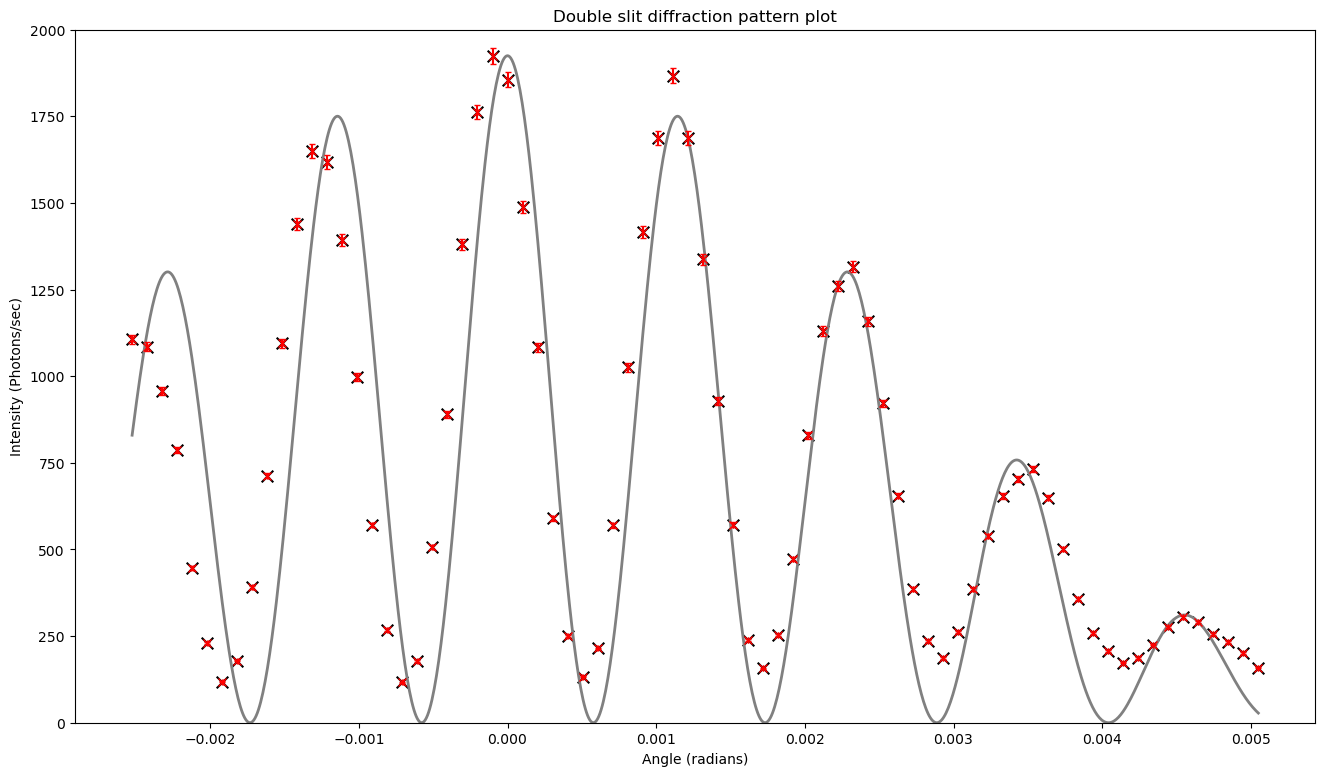

In [763]:
DS_single_photon = reset_data("DS_single_photon")
DS_single_photon =  np.column_stack((DS_single_photon, (DS_single_photon[:, 0] - 2.51)))
DS_single_photon[:, 5] = np.arctan(1/L * DS_single_photon[:, 5])


# Optimize curve
lambda_bounds = [(300e-9, 900e-9)]
result_photon = minimize(objective_photons, x0=initial_lambda_guess, method='Nelder-Mead', bounds=lambda_bounds, tol = 1*100)
optimized_lambda_photon = result.x[0]
print(result)

theta_dense_photons = np.linspace(DS_single_photon[:,5].min(), DS_single_photon[:,5].max(), 1000)
theo_intensity_photons = 1925/Max_double_slit_voltage * double_slit_intensity(theta_dense_photons, optimized_lambda_photon)
# print(theo_intensity_photons)
# Making the curve nice
plt.figure(figsize=(16, 9))
plt.scatter(DS_single_photon[:, 5], DS_single_photon[:, 4], color='black', label = 'diffraction pattern', marker = 'x', s =70)
# plt.scatter(Double_Slit[:, 2], Double_Slit[:, 1], color='black', label = 'diffraction pattern', marker = 'x', s =70)
plt.plot(theta_dense_photons, theo_intensity_photons , color='gray', lw=2, 
         label=f'Theoretical fit, λ = {optimized_lambda_photon*1e9:.1f} nm')
plt.errorbar(DS_single_photon[:, 5], DS_single_photon[:, 4], 
             xerr = 1/(L**2 * DS_single_photon[:, 0]**2) * np.sqrt((L*0.005)**2 + (DS_single_photon[:, 0] * 0.5)**2), 
             yerr = DS_single_photon[:, 4] * 0.01185, fmt='x', color='red', label='Data with error bars', capsize=2)# plt.figure(figsize=(10, 6))
plt.ylim(0, 2000)
plt.xlabel('Angle (radians)')
plt.ylabel('Intensity (Photons/sec)')
plt.title('Double slit diffraction pattern plot')